In [46]:
import wandb
import pandas as pd
import os
from tqdm import tqdm

from table_plotter import print_result_table

In [47]:
api = wandb.Api(timeout=600)


In [48]:
# get all runs for a project
runs = api.runs("inchangbaek4907/pcgrl-llm")
len(runs)

269

In [49]:
# Specify cache directory
cache_dir = "./wandb_cache"
os.makedirs(cache_dir, exist_ok=True)

dfs = []
skipped_runs = []  # List to store IDs of skipped runs

for run in tqdm(runs):
    # Skip the run if it's not finished
    if run.state != "finished":
        print(f"Skipping run {run.id} (state: {run.state})")
        skipped_runs.append(run.id)
        continue

    # Define cache filename based on run ID
    cache_file = os.path.join(cache_dir, f"{run.id}.csv")
    
    # Check if cached file exists
    if os.path.exists(cache_file):
        # Load cached DataFrame
        df = pd.read_csv(cache_file)
    else:
        try:
            # Retrieve history data for Evaluation/similarity and diversity
            sim = run.history(keys=["Evaluation/similarity", "Evaluation/llm_iteration"])
            div = run.history(keys=["Evaluation/diversity", "Evaluation/llm_iteration"])
            llm_sim = run.history(keys=["Evaluation/llm/similarity", "Evaluation/llm_iteration"])
            llm_div = run.history(keys=["Evaluation/llm/diversity", "Evaluation/llm_iteration"])

            # Sequentially merge the DataFrames on "Evaluation/llm_iteration"
            df = pd.merge(sim, div, on="Evaluation/llm_iteration", how="outer")
            df = df.drop(columns=["_step_x", "_step_y"], errors="ignore")
            if 'Evaluation/llm_iteration' in llm_sim.columns:
                df = pd.merge(df, llm_sim, on="Evaluation/llm_iteration", how="outer")
                df = df.drop(columns=["_step_x", "_step_y"], errors="ignore")
            if 'Evaluation/llm_iteration' in llm_div.columns:
                df = pd.merge(df, llm_div, on="Evaluation/llm_iteration", how="outer")
                df = df.drop(columns=["_step_x", "_step_y"], errors="ignore")

            # Now, 'df' contains all the merged data based on "Evaluation/llm_iteration"

            df = df.drop(columns=["_step_x", "_step_y"], errors="ignore")

            # Add run config to DataFrame with prefix 'config.'
            for key, value in run.config.items():
                if isinstance(value, list):
                    value = ",".join(map(str, value))  # Convert list to comma-separated string
                df[key] = value

            # Filter columns
            key_filter = ['target_character', 'pe', 'branch_factor', 'exp_name', 'evaluator', 'total_iterations',
                          'reward_feature', 'fewshot', 'problem', 'seed', 'Evaluation/llm_iteration',
                          'Evaluation/similarity', 'Evaluation/diversity']
            auxiliary_key_filter = ['Evaluation/llm/similarity', 'Evaluation/llm/diversity']

            try:
                df = df[key_filter + auxiliary_key_filter]
            except KeyError:
                df = df[key_filter]

            # Save DataFrame to cache as CSV
            df.to_csv(cache_file, index=False)
        except KeyError:
            continue
    
    # Append DataFrame to list
    dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)
df.head()  # Display the first few rows for inspection

# Print summary of skipped runs
print("\nSummary of Skipped Runs:")
print(f"Total skipped runs: {len(skipped_runs)}")
print("Skipped run IDs:", skipped_runs)

100%|██████████| 269/269 [00:05<00:00, 52.59it/s]

Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-D_s-1 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-F_s-1 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-M_s-1 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-N_s-1 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-C_s-1 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-N_s-2 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-C_s-3 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-F_s-3 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-M_s-2 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-N_s-3 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-C_s-2 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-M_s-3 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-longiter_chr-F_s-2 (state: crashed)
Skipping run pe-got_it-15_fit-vit_exp-

In [50]:
time_str = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")

In [51]:
df.to_csv(f"wandb_output_{time_str}.csv", index=False)

In [52]:

df['seed'] = df['seed'] % 3
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,F,got,2,noscoregot,vit,6,array,False,binary,0,2,0.205068,0.189728,NaN,NaN
1410,F,got,2,noscoregot,vit,6,array,False,binary,0,3,0.205068,0.189728,NaN,NaN
1411,F,got,2,noscoregot,vit,6,array,False,binary,0,4,0.389772,0.191404,NaN,NaN
1412,F,got,2,noscoregot,vit,6,array,False,binary,0,5,0.243931,0.150535,NaN,NaN


In [53]:
# remove pe == cotsc
df = df[df['pe'] != 'cotsc']

# if the exname is not def make the pe to 'pe+exp_name'
df['pe'] = df.apply(lambda x: x['pe'] + '-' +  x['exp_name'] if x['exp_name'] != 'def' else x['pe'], axis=1)

C:\Users\GIST\AppData\Local\Temp\ipykernel_25036\1595903143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pe'] = df.apply(lambda x: x['pe'] + '-' +  x['exp_name'] if x['exp_name'] != 'def' else x['pe'], axis=1)


In [54]:
df.groupby(['pe', 'evaluator', 'fewshot', 'seed']).count()

target_character  branch_factor  \
pe             evaluator fewshot seed                                    
cot            vit       False   0                   24             24   
                                 1                   24             24   
                                 2                    6              6   
                         True    0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
cot-4omini     vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
cot-encfb      vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   29             29   
got            llm       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
               vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   25             25   
                         True    0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
got-4omini     vit       False   0                   30             30   
                                 1                   23             23   
                                 2                   25             25   
got-encfb      vit       False   0                   28             28   
                                 1                   25             25   
                                 2                   30             30   
got-noscoregot vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
io             vit       False   0                    5              5   
                                 1                    5              5   
                                 2                    5              5   
tot            llm       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
               vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
                         True    0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
tot-4omini     vit       False   0                   30             30   
                                 1                   26             26   
                                 2                   24             24   
tot-6b         vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   
tot-encfb      vit       False   0                   30             30   
                                 1                   30             30   
                                 2                   30             30   

                                       exp_name  total_iterations  \
pe             evaluator fewshot seed          

In [55]:
# Min-max Normalize Evaluation/similarity and Evaluation/diversity for each 'target_character' and add a new column 'Evaluation/similarity/norm' and 'Evaluation/diversity/norm'
df['Evaluation/similarity/norm'] = df.groupby('target_character')['Evaluation/similarity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Evaluation/diversity/norm'] = df.groupby('target_character')['Evaluation/diversity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df

C:\Users\GIST\AppData\Local\Temp\ipykernel_25036\254095163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Evaluation/similarity/norm'] = df.groupby('target_character')['Evaluation/similarity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
C:\Users\GIST\AppData\Local\Temp\ipykernel_25036\254095163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Evaluation/diversity/norm'] = df.groupby('target_character')['Evaluation/diversity'].transform(lambda x: (x - x.min()) / (x.max() - x.min(

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity,Evaluation/similarity/norm,Evaluation/diversity/norm
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN,0.010901,1.000000
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN,0.045733,0.259777
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN,0.950957,0.000000
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN,0.034002,0.265148
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN,0.947941,0.000649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,F,got-noscoregot,2,noscoregot,vit,6,array,False,binary,0,2,0.205068,0.189728,NaN,NaN,0.234873,0.386594
1410,F,got-noscoregot,2,noscoregot,vit,6,array,False,binary,0,3,0.205068,0.189728,NaN,NaN,0.234873,0.386594
1411,F,got-noscoregot,2,noscoregot,vit,6,array,False,binary,0,4,0.389772,0.191404,NaN,NaN,0.457371,0.390010
1412,F,got-noscoregot,2,noscoregot,vit,6,array,False,binary,0,5,0.243931,0.150535,NaN,NaN,0.281688,0.306733


In [56]:
exp4_df = df[df['pe'].isin(['io','got','cot','tot'])]
exp4_df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity,Evaluation/similarity/norm,Evaluation/diversity/norm
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN,0.010901,1.000000
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN,0.045733,0.259777
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN,0.950957,0.000000
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN,0.034002,0.265148
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN,0.947941,0.000649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,C,tot,2,def,vit,6,array,True,binary,0,2,0.044665,0.000000,NaN,NaN,0.047391,0.000000
720,C,tot,2,def,vit,6,array,True,binary,0,3,0.193625,0.153446,NaN,NaN,0.233466,0.286957
721,C,tot,2,def,vit,6,array,True,binary,0,4,0.210502,0.075594,NaN,NaN,0.254549,0.141367
722,C,tot,2,def,vit,6,array,True,binary,0,5,0.031002,0.000000,NaN,NaN,0.030325,0.000000


In [57]:
result_similarity = (
    exp4_df.groupby(['pe', 'Evaluation/llm_iteration'])['Evaluation/similarity/norm']
    .agg(['mean', 'std'])
    .reset_index()
)
print(result_similarity)

     pe  Evaluation/llm_iteration      mean       std
0   cot                         1  0.233551  0.325305
1   cot                         2  0.181073  0.306372
2   cot                         3  0.196686  0.336451
3   cot                         4  0.171758  0.300809
4   cot                         5  0.185232  0.283025
5   cot                         6  0.193742  0.322839
6   got                         1  0.271934  0.329068
7   got                         2  0.208468  0.333905
8   got                         3  0.172906  0.277864
9   got                         4  0.177691  0.283135
10  got                         5  0.224267  0.333516
11  got                         6  0.202152  0.301264
12   io                         1  0.202461  0.329572
13  tot                         1  0.286566  0.338725
14  tot                         2  0.143146  0.263422
15  tot                         3  0.179714  0.315750
16  tot                         4  0.125977  0.219840
17  tot                     

In [58]:
result_diversity = (
    exp4_df.groupby(['pe', 'Evaluation/llm_iteration'])['Evaluation/diversity/norm']
    .agg(['mean', 'std'])
    .reset_index()
)
print(result_diversity)

     pe  Evaluation/llm_iteration      mean       std
0   cot                         1  0.145460  0.229029
1   cot                         2  0.230979  0.195523
2   cot                         3  0.225842  0.227639
3   cot                         4  0.214616  0.217851
4   cot                         5  0.323950  0.234288
5   cot                         6  0.246488  0.260771
6   got                         1  0.174135  0.247294
7   got                         2  0.256905  0.233768
8   got                         3  0.240040  0.259177
9   got                         4  0.252089  0.243609
10  got                         5  0.206865  0.208559
11  got                         6  0.222773  0.216103
12   io                         1  0.300732  0.309115
13  tot                         1  0.222890  0.267960
14  tot                         2  0.200135  0.214952
15  tot                         3  0.225850  0.220340
16  tot                         4  0.288751  0.239389
17  tot                     

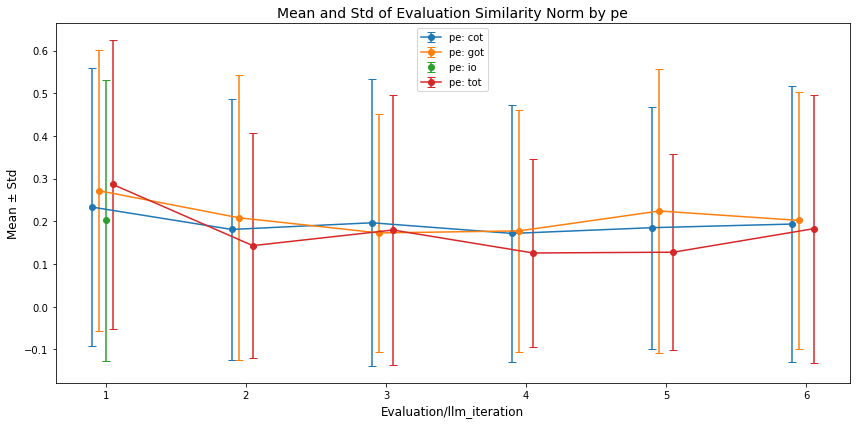

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x_values = sorted(result_similarity['Evaluation/llm_iteration'].unique())

pe_values = result_similarity['pe'].unique()

x_positions = np.arange(len(x_values))
offset = 0.05  # pe 간 간격 조정

plt.figure(figsize=(12, 6))

for i, pe in enumerate(pe_values):
    pe_data = result_similarity[result_similarity['pe'] == pe]
    x_values_pe = pe_data['Evaluation/llm_iteration'].to_numpy() - 1  # pe에 해당하는 x 값
    means = pe_data['mean'].to_numpy()  # pe에 해당하는 mean 값
    stds = pe_data['std'].to_numpy()   # pe에 해당하는 std 값

    adjusted_x = x_values_pe + (i - len(pe_values) / 2) * offset


    if pe == 'io':
        # 주석 체크(errorbar on/off)
        # plt.scatter(x_values_pe, means, label=f'pe: {pe}', s=50)
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='o', label=f'pe: {pe}', capsize=4)
    else:
        # plt.plot(x_values_pe, means, marker='o', label=f'pe: {pe}')
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='-o', label=f'pe: {pe}', capsize=4)

plt.xlabel('Evaluation/llm_iteration', fontsize=12)
plt.ylabel('Mean ± Std', fontsize=12)
plt.title('Mean and Std of Evaluation Similarity Norm by pe', fontsize=14)
plt.xticks(x_positions, x_values)  # x축 값 중앙 정렬
plt.legend()
plt.tight_layout()

# 그래프 표시
plt.show()


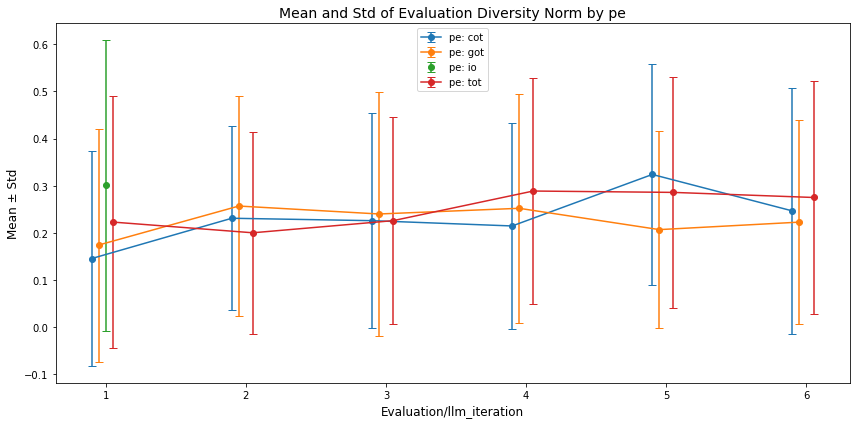

In [60]:
import matplotlib.pyplot as plt
import numpy as np

x_values = sorted(result_diversity['Evaluation/llm_iteration'].unique())

pe_values = result_diversity['pe'].unique()

x_positions = np.arange(len(x_values))
offset = 0.05  # pe 간 간격 조정

plt.figure(figsize=(12, 6))


for i, pe in enumerate(pe_values):
    pe_data = result_diversity[result_diversity['pe'] == pe]
    x_values_pe = pe_data['Evaluation/llm_iteration'].to_numpy() -1  # pe에 해당하는 x 값
    means = pe_data['mean'].to_numpy()  # pe에 해당하는 mean 값
    stds = pe_data['std'].to_numpy()   # pe에 해당하는 std 값


    adjusted_x = x_values_pe + (i - len(pe_values) / 2) * offset

    if pe == 'io':
        # 주석 체크(errorbar on/off)
        # plt.scatter(x_values_pe, means, label=f'pe: {pe}', s=50)
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='o', label=f'pe: {pe}', capsize=4)
    else:
        # plt.plot(x_values_pe, means, marker='o', label=f'pe: {pe}')
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='-o', label=f'pe: {pe}', capsize=4)

# 축 레이블 및 제목 설정
plt.xlabel('Evaluation/llm_iteration', fontsize=12)
plt.ylabel('Mean ± Std', fontsize=12)
plt.title('Mean and Std of Evaluation Diversity Norm by pe', fontsize=14)
plt.xticks(x_positions, x_values)  # x축 값 중앙 정렬
plt.legend()
plt.tight_layout()

# 그래프 표시
plt.show()
